# Multiagent Table Analysis
### Suhas Raja 06/2020

#### Imports

In [1]:
import json
import scipy.integrate as integ
%matplotlib inline
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import random as rd

## Class Definitions

### Seat

In [25]:
class Seat:
    def __init__(self,ID,x,y,theta):
        self.x=x
        self.y=y
        self.theta=theta%360
        self.currTheta=theta%360
        self.ID=ID
        self.assignee = None
        self.degVal=dict()
        self.degValX=list()
        self.degValY=list()
        self.deltTheta=0
    def __compute_view_value__(self,ang,seat,candidate):
        from math import sqrt, sin, cos, atan, radians, degrees
        #Rotate based on self perspective
        other_theta = (seat.currTheta + 90-ang)%360
        ang = radians((90-ang)%360)
        deltX   = seat.x-self.x
        deltY   = seat.y-self.y
        other_x = cos(ang)*deltX-sin(ang)*deltY
        other_y = sin(ang)*deltX+cos(ang)*deltY
        #If they're behind you, ignore.
        if other_y<-.01: return 0
        #Distance from self to other. Subtracts to simulate depth of field.
        other_dist=max(1,5-sqrt(deltX**2+deltY**2))
        #Find abs angle from direct line of sight
        try: peerAng = degrees(atan(abs(other_y/other_x)))-90
        except: peerAng=0
        #Normalize abs angle into a scaling factor
        minfact=.25
        maxAng=90/(1-minfact)
        deltang = (maxAng-abs(peerAng))/maxAng
        #Find angle of incidence
        incidence = abs(other_theta+180-90)%360
        if incidence>180: incidence=360-incidence
        lam_incidence=1-incidence/150
        #Scale by friendship factor
        ff=1
        if seat.assignee!=None and candidate!=None: ff = candidate.relationships[seat.assignee.ID]
        return other_dist*deltang*lam_incidence*ff
    def gradePosition(self, Seats, thetaOff=0, candidate=None):
        if candidate==None and self.assignee!=None: candidate=self.assignee
        theta=self.currTheta+thetaOff
        score = 0
        for deg in range(-80,81):
            currScore=0
            for seat in Seats.values():
                if seat.ID!=self.ID:
                    currScore += (self.__compute_view_value__((theta+deg)%360,seat,candidate))
            self.degVal[deg]=currScore
            score+=currScore*(150-abs(deg))/150
        return score/160
    def plotFOVVals(self,scale=False):
        points = sorted(((k,v) for k,v in self.degVal.items()), key=lambda x: x[0])
        x=list()
        y=list()
        for p in points:
            x.append(p[0])
            y.append(p[1]*(250-abs(p[0]*scale)))
        plt.plot(x,y)
        self.degValX=x
        self.degValY=y
        return x,y
    def chooseDir(self,Seats):
        arr=list()
        for i in range(-1,2):
            arr.append(self.gradePosition(Seats,thetaOff=i))
        self.deltTheta=arr.index(max(arr))-1
    def applyThetaDelt(self):
        if abs((((self.currTheta+self.deltTheta)%360)-self.theta)%360)<90:
            self.currTheta =(self.currTheta + self.deltTheta)%360

### Person

In [26]:
class Person:
    def __init__(self,ID):
        self.ID=ID
        self.seat = None
        self.relationships=dict()
    def generateRelationships(self,people):
        if self.ID==3: #outcast
            for k,i in people.items():
                if i.ID!=self.ID:
                    self.relationships[i.ID] = .6
                    i.relationships[self.ID] = .4
        else:
            for k,i in people.items():
                if i.ID!=self.ID:
                    self.relationships[i.ID] = rd.gauss(1,.2)
                    i.relationships[self.ID] = self.relationships[i.ID]+rd.gauss(0,.07)
    def assignSeat(self,seat):
        self.seat = seat
        seat.assignee=self

## Data Construction

/Users/suhas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


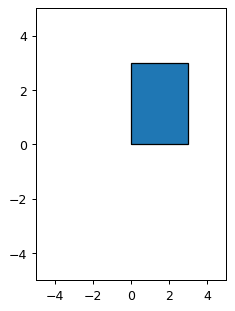

In [27]:
#Pull in data for a particular table
datasets = json.loads(open("table_data.json",'r').read())
table = 'picnic'
N = len(datasets[table].keys())
seats = {int(k):Seat(int(k),v[0],v[1],v[2]) for k,v in datasets[table].items()}
people = {int(k):Person(k) for k in seats.keys()}
for k,person in people.items():
    person.generateRelationships(people)

#Plot Table
fig = plt.figure(5, dpi=90)
ax = fig.add_subplot(121)
coords = list((seat.x,seat.y) for l,seat in seats.items())
polygon = Polygon(coords)
if polygon.is_valid==False: polygon=polygon.convex_hull #todo concavity is tough
patch = PolygonPatch(polygon)
ax.add_patch(patch)
plt.xlim(-5,5)
plt.ylim(-5,5)
fig.show()

In [28]:
# Set each person to seat with ID
## for i in range(N):
##    people[i].assignSeat(seats[i])

# Simulate a line
peopleIDs=list(range(N))
rd.shuffle(peopleIDs)
print(peopleIDs)
for i in range(N):
    maxSeatVal=-1000
    maxSeat = None
    for k, seat in seats.items():
        if seat.assignee==None:
            z = seat.gradePosition(seats,candidate=people[i])
            if z > maxSeatVal:
                maxSeat=seat
                maxSeatVal=z
            print("Person {} Seat {} Value {} maxVal {}".format(i,k,z,maxSeatVal))
    people[i].assignSeat(maxSeat)

[1, 0, 2, 3]
Person 0 Seat 0 Value 1.1949125000000003 maxVal 1.1949125000000003
Person 0 Seat 1 Value 1.1949124999999996 maxVal 1.1949125000000003
Person 0 Seat 2 Value 1.1949124999999996 maxVal 1.1949125000000003
Person 0 Seat 3 Value 1.1949125 maxVal 1.1949125000000003
Person 1 Seat 1 Value 1.1915028663634364 maxVal 1.1915028663634364
Person 1 Seat 2 Value 1.113480421856239 maxVal 1.1915028663634364
Person 1 Seat 3 Value 1.163431189574757 maxVal 1.1915028663634364
Person 2 Seat 2 Value 1.1848966029241992 maxVal 1.1848966029241992
Person 2 Seat 3 Value 1.4558966827762978 maxVal 1.4558966827762978
Person 3 Seat 2 Value 0.7169474999999997 maxVal 0.7169474999999997


### Initial viewports for each seat

Average Score is 568.7705535936432


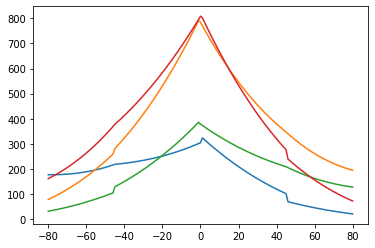

In [29]:
ave=0
for i in range(N):
    seats[i].gradePosition(seats)
    x,y=seats[i].plotFOVVals(scale=True)
    ave+=y[80]/N
print("Average Score is {}".format(ave))

In [30]:
for i in range(N):
    print(seats[i].currTheta)

90
90
270
270


### Emergent viewports 

Average Score is 509.1182055740865


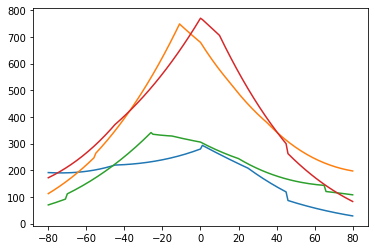

In [31]:
epochs=100
for _ in range(epochs):
    for i in range(N):
        seats[i].chooseDir(seats)
    for i in range(N):
        seats[i].applyThetaDelt()
ave=0
for i in range(N):
    seats[i].gradePosition(seats)
    x,y=seats[i].plotFOVVals(scale=True)
    ave+=y[80]/N
print("Average Score is {}".format(ave))

In [32]:
for i in range(N):
    print(seats[i].currTheta)

90
100
295
270


In [23]:
for k,v in seats.items():
    print(v.assignee)

None
None
None
